In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare and Custom Data Folder

In [ ]:
!wget https://motchallenge.net/data/MOT17.zip
!unzip /content/MOT17.zip

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install ultralytics
!pip install gdown


Streaming output truncated to the last 5000 lines.
  inflating: MOT17/train/MOT17-04-DPM/img1/000876.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000321.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000447.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000453.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000335.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/001003.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/001017.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000309.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000484.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000490.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000255.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000533.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000527.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000241.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000269.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000296.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000282.jpg

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision import transforms as transforms
from ultralytics import YOLO
from tqdm import tqdm
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def convert_to_yolo_box(bbox,img_width,img_height,format='coco'):
    '''
    parameters:
      bbox: np.ndarray[class_id,xmin,ymin,box_width,box_heigh] if type 'coco' else [class_id,xmin,ymin,xmax,ymax]
    return:
      yolo format : np.ndarray[class_id,x_center,y_center,box_width,box_height] scaled in range (0,1)
    '''
    if(format=='coco'): # xmin,ymin,width,height
      x_center=(bbox[...,1]+(bbox[...,3]/2))/img_width
      y_center=(bbox[...,2]+(bbox[...,4]/2))/img_height
      box_width=bbox[...,3]/img_width
      box_height=bbox[...,4]/img_height
    elif(format=='voc'):
      x_center=((bbox[...,1]+bbox[...,3])/2)/img_width
      y_center=((bbox[...,2]+bbox[...,4])/2)/img_height
      box_width=(bbox[...,3]-bbox[...,1])/img_width
      box_height=(bbox[...,4]-bbox[...,2])/img_height
    return np.clip(np.round(np.array([0,x_center,y_center,box_width,box_height]),6),0,1)

In [ ]:
import configparser

def make_yolo_dir(data_path,new_path):
    if(os.path.isdir(new_path)):
      shutil.rmtree(new_path)
    img_path=os.path.join(new_path,'images')
    label_path=os.path.join(new_path,'labels')

    for phrase in os.listdir(data_path):
      original_phrase_path=os.path.join(data_path,phrase)
      for fol in os.listdir(original_phrase_path):
        config = configparser.ConfigParser()
        config.read(os.path.join(original_phrase_path,fol,'seqinfo.ini'))
        img_width=int(config['Sequence']['imWidth'])
        img_height=int(config['Sequence']['imHeight'])

        original_img_path=os.path.join(original_phrase_path,fol,'img1')
        original_label_path=os.path.join(original_phrase_path,fol,'det')

        if(phrase=='train' and 'SDP' in fol):

          os.makedirs(os.path.join(img_path,'train'),exist_ok=True)
          os.makedirs(os.path.join(label_path,'train'),exist_ok=True)

          for original_img in tqdm(os.listdir(original_img_path)):
             shutil.copy2(src=os.path.join(original_img_path,original_img),dst=os.path.join(img_path,'train',f'train_{"".join(fol.split("-"))}{original_img}'))
          for id,row in tqdm(pd.read_csv(os.path.join(original_label_path,'det.txt'),names=['frame','id','xmin','ymin','width','height','visibility']).iterrows()):
              with open(os.path.join(label_path,'train',f'train_{"".join(fol.split("-"))}{int(row.loc["frame"]):06d}.txt'),"a") as f:
                  f.write(" ".join(map(str, convert_to_yolo_box(row[['id','xmin','ymin','width','height']].values,img_width,img_height))) + "\n")
        elif(phrase=='test' and 'SDP' in fol):

          os.makedirs(os.path.join(img_path,'val'),exist_ok=True)
          os.makedirs(os.path.join(label_path,'val'),exist_ok=True)

          for original_img in tqdm(os.listdir(original_img_path)):
             shutil.copy2(src=os.path.join(original_img_path,original_img),dst=os.path.join(img_path,'val',f'val_{"".join(fol.split("-"))}{original_img}'))
          for id,row in tqdm(pd.read_csv(os.path.join(original_label_path,'det.txt'),names=['frame','id','xmin','ymin','width','height','visibility']).iterrows()):
              with open(os.path.join(label_path,'val',f'val_{"".join(fol.split("-"))}{int(row.loc["frame"]):06d}.txt'),"a") as f:
                  f.write(" ".join(map(str, convert_to_yolo_box(row.loc[['id','xmin','ymin','width','height']].values,img_width,img_height))) + "\n")

        else: continue


In [ ]:
new_path='/content/new_mot17'
data_path='/content/MOT17'
config_path="/content/new_mot17/yolo_config.yaml"

make_yolo_dir(data_path,new_path)

100%|██████████| 750/750 [00:02<00:00, 308.97it/s]
10461it [00:11, 890.51it/s]
100%|██████████| 500/500 [00:01<00:00, 364.01it/s]
10273it [00:05, 1847.01it/s]
100%|██████████| 1194/1194 [00:00<00:00, 1199.87it/s]
8283it [00:04, 2065.14it/s]
100%|██████████| 900/900 [00:01<00:00, 542.48it/s]
5440it [00:03, 1528.31it/s]
100%|██████████| 1500/1500 [00:04<00:00, 363.04it/s]
80241it [00:38, 2095.34it/s]
100%|██████████| 450/450 [00:00<00:00, 528.80it/s]
5837it [00:02, 2203.98it/s]
100%|██████████| 625/625 [00:01<00:00, 352.97it/s]
8118it [00:04, 1726.80it/s]
100%|██████████| 750/750 [00:02<00:00, 346.65it/s]
7744it [00:03, 2099.54it/s]
100%|██████████| 525/525 [00:01<00:00, 344.55it/s]
3607it [00:01, 2098.98it/s]
100%|██████████| 837/837 [00:00<00:00, 1106.93it/s]
4767it [00:02, 2048.77it/s]
100%|██████████| 654/654 [00:01<00:00, 491.24it/s]
10371it [00:05, 1875.40it/s]
100%|██████████| 1050/1050 [00:02<00:00, 374.56it/s]
37150it [00:18, 1981.33it/s]
100%|██████████| 600/600 [00:01<00:00, 4

In [ ]:
import yaml

yaml_data={
    "path":new_path,
    "train":"images/train",
    "val":f"images/val",
    "nc":1,
    "names":[
        "person"
    ]
}

with open(config_path,'w') as f:
    yaml.dump(yaml_data,f, default_flow_style=False)

# Detector

## Train Detector

In [ ]:
model = YOLO("yolo11n.pt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs=10
bs=-1
project='/content/drive/MyDrive/yolo11'
name='log'

100%|██████████| 5.35M/5.35M [00:00<00:00, 89.4MB/s]


In [ ]:
results = model.train(data="/content/new_mot17/yolo_config.yaml", epochs=epochs, device=device,batch=bs,project=project,name=name)

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/new_mot17/yolo_config.yaml, epochs=10, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=/content/drive/MyDrive/yolo11, name=log3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, ker

100%|██████████| 755k/755k [00:00<00:00, 21.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/new_mot17/labels/train... 5310 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5316/5316 [00:02<00:00, 2038.26it/s]


train: New cache created: /content/new_mot17/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590035       6.441         0.461         79.48         561.7        (1, 3, 640, 640)                    list
     2590035       12.88         0.610          36.9         115.1        (2, 3, 640, 640)                    list
     2590035       25.76         0.929         32.54         98.51        (4, 3, 640, 640)                    list
     2590035       51.52         1.577         33.62           111        (8, 3, 640, 

train: Scanning /content/new_mot17/labels/train.cache... 5310 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5316/5316 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/new_mot17/labels/val... 5913 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:10<00:00, 539.89it/s]


val: New cache created: /content/new_mot17/labels/val.cache
Plotting labels to /content/drive/MyDrive/yolo11/log3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0007968750000000001), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/yolo11/log3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      15.3G      1.596      1.728      1.135        202        640: 100%|██████████| 53/53 [02:16<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:35<00:00,  3.19s/it]


                   all       5919     128653     0.0669      0.924      0.547      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      15.3G      1.398     0.9513      1.045        230        640: 100%|██████████| 53/53 [02:09<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:36<00:00,  3.22s/it]


                   all       5919     128653      0.833      0.688      0.811      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      15.3G      1.378      0.876      1.046        190        640: 100%|██████████| 53/53 [02:05<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:30<00:00,  3.03s/it]


                   all       5919     128653      0.839      0.742      0.843      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      15.2G      1.335     0.7925      1.037        112        640: 100%|██████████| 53/53 [02:06<00:00,  2.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:28<00:00,  2.96s/it]


                   all       5919     128653      0.866      0.768      0.869      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      15.3G      1.284     0.7301      1.012        141        640: 100%|██████████| 53/53 [02:00<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:29<00:00,  2.97s/it]


                   all       5919     128653      0.872      0.793      0.894      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      15.3G      1.249     0.6883      1.002        131        640: 100%|██████████| 53/53 [02:04<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:23<00:00,  2.78s/it]


                   all       5919     128653      0.887      0.793      0.897      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      15.3G      1.213     0.6537     0.9871        219        640: 100%|██████████| 53/53 [02:02<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:27<00:00,  2.90s/it]


                   all       5919     128653       0.89      0.797      0.899      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      15.3G      1.182     0.6293     0.9734        209        640: 100%|██████████| 53/53 [02:03<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:19<00:00,  2.66s/it]


                   all       5919     128653      0.895      0.821       0.91      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      14.7G      1.149      0.605     0.9638        201        640: 100%|██████████| 53/53 [02:00<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:22<00:00,  2.73s/it]


                   all       5919     128653      0.898      0.788      0.897      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      15.3G      1.125     0.5841     0.9556        206        640: 100%|██████████| 53/53 [01:59<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:26<00:00,  2.87s/it]


                   all       5919     128653        0.9      0.805      0.908      0.579

10 epochs completed in 0.617 hours.
Optimizer stripped from /content/drive/MyDrive/yolo11/log3/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/MyDrive/yolo11/log3/weights/best.pt, 5.5MB

Validating /content/drive/MyDrive/yolo11/log3/weights/best.pt...
Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [01:51<00:00,  3.70s/it]


                   all       5919     128653      0.899      0.805      0.908      0.579
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11/log3


## Eval Detector

In [1]:
def drawBox(img,bboxes,labels=None):
    new_img=img.copy()
    for i,box in enumerate(bboxes):
      xmin,ymin,xmax,ymax = box.astype('int')
      if(labels is None):
        labels=['']*len(bboxes)
      (label_width, label_height), baseline = cv2.getTextSize(str(labels[i]), cv2.FONT_HERSHEY_SIMPLEX, 0.3, 1)
      new_img=cv2.rectangle(new_img, (xmin,ymin-(label_height+baseline+4)), (xmin+label_width+2,ymin), (0,255,0), thickness=cv2.FILLED)
      new_img = cv2.putText(new_img, str(labels[i]), (xmin,ymin-5),cv2.FONT_HERSHEY_SIMPLEX,
                    0.3, (0,0,0),1,cv2.LINE_AA)
      new_img = cv2.rectangle(new_img,(xmin,ymin),(xmax,ymax),color=(0,255,0))
    return new_img

In [ ]:
def plot_eval(model):
  import glob
  root_img_path=os.path.join(data_path,'test/*','img1/*jpg')
  img_path= glob.glob(root_img_path)
  fig, axs = plt.subplots(2, 3, figsize=(10, 3))
  for i in range(6):
      rand_idx=np.random.randint(0,len(img_path)-1)
      img_idx_path=img_path[rand_idx]
      pred=model(img_idx_path,verbose=False)[0].cpu().numpy()
      bboxes=pred.boxes.xyxy #voc format
      pred_original_img=pred.orig_img
      ax = axs[i // 3, i % 3]  # Tính toán vị trí axes
      ax.imshow(drawBox(pred_original_img,bboxes,pred.boxes.cls))  # Vẽ hình ảnh
      ax.axis('off')
  plt.show()

In [ ]:
trained_yolo_path=os.path.join(project,name,'weights/best.pt')
best_model=YOLO(trained_yolo_path)

In [ ]:
result = best_model.val(project=project,name='log/val')

Ultralytics 8.3.73 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/new_mot17/labels/val.cache... 5913 images, 6 backgrounds, 0 corrupt: 100%|██████████| 5919/5919 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 370/370 [01:47<00:00,  3.44it/s]


                   all       5919     128653      0.899      0.806      0.908      0.579
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/yolo11/log/val6




**mAP50 score: 0.908 cho thấy mô hình đã khá tốt cho việc phát hiện bndbox với mức IoU >50%**

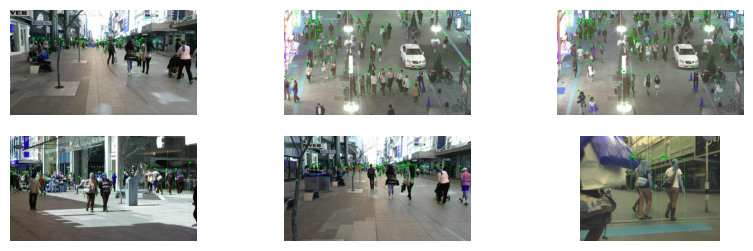

In [ ]:
plot_eval(best_model)